# SuperTomo2 mv_registration class testing

In [13]:
%matplotlib inline
import os
import numpy
from IPython.html.widgets import interact, fixed

from supertomo.ui import arguments                     # Command line arguments
from supertomo.io import image_data                    # Data structure
from supertomo.reconstruction import registration_mv   # Image registration functions
from supertomo.ui import show
from supertomo.utils import itkutils


def show_side_by_side(layer, image1, image2):
    show.display_2d_images(image1[layer, :, :], image2[layer, :, :], image1_title='Fixed', image2_title='Moving')

## Arguments

The behavior of all the scripts in *SuperTomo* is controlled by command line arguments. Here the argument list is simulated with a single string, split at spaces, just like is done with argv. 

In [14]:
fuse_args = ("test_file_3.hdf5 --dir=/home/sami/Data/2016_09_tomoSTED_bhk_single_structure/Import " 
             "--sampling-percentage=1 --mattes-histogram-bins=30 "     
             "--reg-relax-factor=.8 --learning-rate=1 --min-step=0.0005 "         
             "--reg-max-iterations=300 "
             "--set-rot-axis=1 --scale=50 --reg-method=correlation"               
             ""                                     
            ).split()

print fuse_args

options = arguments.get_register_script_options(fuse_args)

['test_file_3.hdf5', '--dir=/home/sami/Data/2016_09_tomoSTED_bhk_single_structure/Import', '--sampling-percentage=1', '--mattes-histogram-bins=30', '--reg-relax-factor=.8', '--learning-rate=1', '--min-step=0.0005', '--reg-max-iterations=300', '--set-rot-axis=1', '--scale=50', '--reg-method=correlation']


## Load data

The data in *SuperTomo2* is held in a single HDF5 file.

In [15]:
full_path = os.path.join(options.working_directory,
                         options.data_file)

if not os.path.isfile(full_path):
    raise AttributeError("No such file: %s" % full_path)
elif not full_path.endswith(".hdf5"):
    raise AttributeError("Not a HDF5 file")

data = image_data.ImageData(full_path)

## Setup registration

The image registration functions from the original *SuperTomo* were modified to accomodate **N** views, instead of just two. At the same time the image registration method was converted into a class.

In [16]:
task = registration_mv.MultiViewRegistration(data, options)

## Execute

Let's register views number 0 and 1. 0 is always the regular STED image. You can move to a next view by changing the *moving_index*.

In [17]:
fixed_index = 0
moving_index = 1

task.set_fixed_image(fixed_index)
task.set_moving_image(moving_index)
task.execute()

Initializing registration
Starting registration of views 0 (fixed) & 1 (moving)
Final metric value: -0.634800169227
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 138 iterations. Current step (0.000474457) is less than minimum step (0.0005).
itk::simple::AffineTransform
 AffineTransform (0x612b4c0)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 1
   Modified Time: 6228410
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.842372 0.0190573 0.266733 
     0.00368982 0.997029 -0.0901501 
     -0.360647 0.00908751 0.929285 
   Offset: [6.35848e-06, 1.12028e-06, 1.33607e-05]
   Center: [3.27789e-05, 3.02395e-05, 3.83318e-06]
   Translation: [2.79032e-06, 8.05819e-07, 1.54279e-06]
   Inverse: 
     1.05663 -0.0174168 -0.304975 
     0.0331382 1.00155 0.0876487 
     0.409745 -0.0165535 0.956881 
   Singular: 0



# Result

The result is a *Composite* of two spatial transforms: a rigid body Euler3DTransform that handles the initial rotation, and a deformable AffineTransform that is calculated during registration. They are combined into one at the end of the registration progress. 

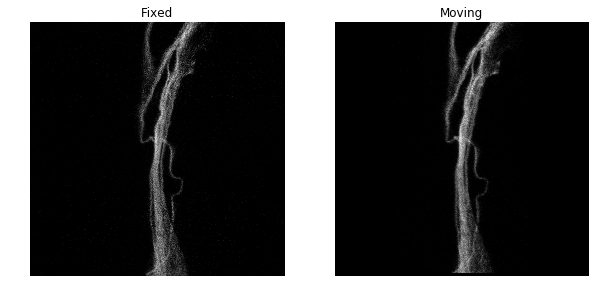

<function __main__.show_side_by_side>

In [18]:
data.set_active_image(fixed_index, options.channel, options.scale, "original")
fixed_image = data.get_itk_image()

result_image = task.get_resampled_result()

interact(show_side_by_side, 
         layer=(0, fixed_image.GetDepth()-1, 1), 
         image1=fixed(itkutils.convert_to_numpy(fixed_image)[0]),
         image2=fixed(itkutils.convert_to_numpy(result_image)[0])
         
        )


In [19]:
result = itkutils.make_composite_rgb_image(fixed_image, result_image, return_numpy=True)[0]

show.evaluate_3d_image(result)


# Reapply transformation

Let's finish by testing that the same transorm can be reapplied afterwards with the *Parameters* that are saved to the data structure after image registration.

In [20]:
import SimpleITK as sitk

transform = task.get_final_transform()
print "The transform type is:", transform.GetName()
print
print "The fixed parameters are:"
print transform.GetFixedParameters()
print
print "The parameters are:"
print transform.GetParameters()




The transform type is: AffineTransform

The fixed parameters are:
(3.2778857228994423e-05, 3.0239496390495958e-05, 3.83317533407275e-06)

The parameters are:
(0.8423715457963397, 0.019057251920755476, 0.2667332187305982, 0.0036898178579938285, 0.9970286283688609, -0.0901500914200734, -0.36064718600971357, 0.009087513212950774, 0.9292846902357418, 2.7903178544244134e-06, 8.058187719943908e-07, 1.5427923342447495e-06)


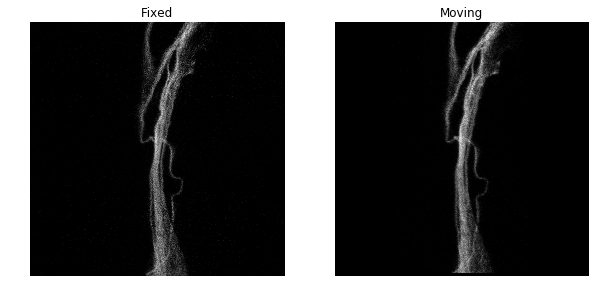

<function __main__.show_side_by_side>

In [21]:
new_transform = sitk.AffineTransform(3)
new_transform.SetFixedParameters(transform.GetFixedParameters())
new_transform.SetParameters(transform.GetParameters())

data.set_active_image(fixed_index, options.channel, options.scale, "original")
fixed_image = data.get_itk_image()

data.set_active_image(moving_index, options.channel, options.scale, "original")
moving_image = data.get_itk_image()

result_image_2 = itkutils.resample_image(moving_image, new_transform, fixed_image)

interact(show_side_by_side, 
         layer=(0, fixed_image.GetDepth()-1, 1), 
         image1=fixed(itkutils.convert_to_numpy(fixed_image)[0]),
         image2=fixed(itkutils.convert_to_numpy(result_image_2)[0])
         
        )


In [22]:
result_2 = itkutils.make_composite_rgb_image(fixed_image, result_image_2, return_numpy=True)[0]

show.evaluate_3d_image(result_2)
